In [1]:
import sys
sys.path.append('../')

# En la siguiente línea se tiene que agregar el directorio donde está instalado dynaconf y simanneal
# (esto es sólo en caso de que python no lo encuentre automáticamente)
sys.path.append('/Users/Marco/miniconda3/envs/dpa-rita/lib/python3.8/site-packages')
sys.path.append('/usr/local/lib/python3.7/site-packages/simanneal')
sys.path.append('/usr/local/lib/python3.7/site-packages')

from models import particle_swarm as ps
from models import simulated_annealing as sa
import Control as ctl
import Utileria as ut

# Pipeline del proyecto

A continuación se mostrará el pipeline del proyecto, desde que se crean las tablas para mostrar la información, hasta que el llenado de la tabla de resultados.

Para llevar a cabo el pipeline de todo el flujo, se crea una clase control desde la cual se mandarán a llamar a las funciones principales para:
-El cargado de la base

-La transformación de datos al formato adecuado de procesamiento

-El procesamiento de las rutas por cada fuerza de ventas

In [2]:
objControl = ctl.Control()

# Carga Inicial

Mediante el siguiente método, sucederá lo siguiente:

-Creación de esquemas

-Creación de tablas

-Creación de vistas

-Carga de información raw (fuerzas de ventas y catálogo de nodos)

-Se eliminarán tablas temporales auxiliares empleadas al momento de la cárga de nodos

In [3]:
%%time
objControl.CargarBase()

./sql/create_schemas.sql
./sql/create_tables.sql
./sql/create_views.sql
./sql/clean_tables.sql
CPU times: user 1.14 s, sys: 258 ms, total: 1.4 s
Wall time: 58.5 s


A continuación se pueden ver las 2 tablas cargadas, fuerza de ventas y el catálogo de ubicaciones de nodos

In [4]:
ut.get_data('select * from raw.fuerza_ventas limit 100;')

Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed


,fza_ventas,no_cliente,lat_destino,lon_destino,id_origen,estado,lat_origen,lon_origen
0,123,10295095,25.78480559,-100.39811999999999,11388,Nuevo León,25.7789,-100.387
1,123,1010290203,25.78390292,-100.3945131,11388,Nuevo León,25.7789,-100.387
2,123,1010290279,25.77787843,-100.4000348,11388,Nuevo León,25.7789,-100.387
3,123,1010291206,25.7624079,-100.39534990000001,11388,Nuevo León,25.7789,-100.387
4,123,1010291416,25.77327423,-100.40975909999999,11388,Nuevo León,25.7789,-100.387
...,...,...,...,...,...,...,...,...
95,3657,1007240657,25.6568298,-100.3199281,11140,Nuevo León,25.6631,-100.29700000000001
96,3657,1007241980,25.6617194,-100.32240279999999,11140,Nuevo León,25.6631,-100.29700000000001
97,3657,1007244274,25.65930749,-100.3273348,11140,Nuevo León,25.6631,-100.29700000000001
98,3657,1011230133,25.6595228,-100.32182320000001,11140,Nuevo León,25.6631,-100.29700000000001


In [5]:
ut.get_data('select * from trabajo.nodos limit 100;')

Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed


,nodo,lat,lon
0,10295095,25.78480559,-100.39811999999999
1,1010290203,25.78390292,-100.3945131
2,1010290279,25.77787843,-100.4000348
3,1010291206,25.7624079,-100.39534990000001
4,1010291416,25.77327423,-100.40975909999999
...,...,...,...
95,1007240657,25.6568298,-100.3199281
96,1007241980,25.6617194,-100.32240279999999
97,1007244274,25.65930749,-100.3273348
98,1011230133,25.6595228,-100.32182320000001


# Transormación de datos

Mediante el siguiente método, se transformará la información en crudo (raw) a una representación óptima de los grafos de conexión de cada empleado:

In [6]:
%%time
objControl.Transform()

Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
copy trabajo.grafos from STDIN CSV HEADER QUOTE '"'
Loaded data into trabajo.grafos
CPU times: user 13min 32s, sys: 13.7 s, total: 13min 45s
Wall time: 19min 7s


A continuación, se puede visualizar el resultado de la transformación de datos:

In [7]:
ut.get_data('select * from trabajo.grafos limit 100;')

Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed


,id_fza_ventas,id_origen,id_destino,distancia
0,123,11388,10295095,1.292627064806362
1,123,11388,1010290203,0.9356097499208941
2,123,11388,1010290279,1.3100970471773907
3,123,11388,1010291206,2.0154558830461426
4,123,11388,1010291416,2.363191705395026
...,...,...,...,...
95,123,1010290279,1020375833,0.3196854762868246
96,123,1010290279,1020378672,1.5520921512775625
97,123,1010290279,1020402351,1.5477926785960074
98,123,1010290279,1020417583,1.2222488843329562


# Cálculo de rutas

## Particle Swarm secuencial
A partir de este momento, se puede comenzar a realizar el cálculo de rutas para todas las fuerzas de venta.

Primero se empleará el algoritmo de Particle Swarm de manera secuencial para medir el tiempo, y posteriormente en paralelo para comparar los tiempos de ejecución.

In [8]:
%%time
objControl.CalcularRutasSeq(ps.ParticleSwarm, objControl.dict_Hiper_PS)

Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  35673
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  87795
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  80060
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  93997
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  94919
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  57635
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  50367
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  54210
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  46388
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_venta

--fza_ventas:  46669
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  40111
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  90709
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  90147
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  84998
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  33369
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  58137
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  89571
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  95826
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  84302
Selecting rows from table using cursor.fetchall
PostgreSQL connection 

Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  78080
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  91814
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  94765
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  37831
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  95678
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  91694
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  81393
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  89009
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  93906
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_venta

--fza_ventas:  75938
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  76079
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  94628
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  88934
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  22729
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  83153
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  95165
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  75889
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  75909
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  85908
Selecting rows from table using cursor.fetchall
PostgreSQL connection 

Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  41895
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  40714
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  86862
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  82832
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  76604
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  76011
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  90300
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  93078
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  85712
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_venta

--fza_ventas:  40963
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  89016
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  56573
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  47430
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  37525
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  29375
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  52689
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  47420
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  57522
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  82522
Selecting rows from table using cursor.fetchall
PostgreSQL connection 

Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  18461
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  80498
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  56654
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  87592
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  40454
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  19685
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  94851
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  72293
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  46579
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_venta

--fza_ventas:  94639
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  85663
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  71531
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  74775
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  41561
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  45502
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  87449
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  94691
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  93840
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  87581
Selecting rows from table using cursor.fetchall
PostgreSQL connection 

Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  85830
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  58091
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  46012
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  86282
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  87797
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  80510
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  22146
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  30098
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  41176
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_venta

--fza_ventas:  47848
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  71608
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  39306
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  92132
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  76849
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  36680
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  85659
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  91092
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  54430
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  57640
Selecting rows from table using cursor.fetchall
PostgreSQL connection 

Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  79569
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  88440
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  39723
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  94405
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  52611
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  44303
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  76633
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  46581
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  80743
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_venta

--fza_ventas:  88928
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  74699
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  85464
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  91696
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  74420
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  75060
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  91560
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  85917
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  34772
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  27449
Selecting rows from table using cursor.fetchall
PostgreSQL connection 

Como se puede apreciar, el tiempo total del procesamiento secuencial fue de alrededor de 40 minutos.

Se eliminarán los registros que previamente fueron cargados para volver a realizar la carga pero ahora en paralelo:

In [9]:
conn = ut.CrearConexionRDS()
ut.EjecutarQuery(conn,'delete from trabajo.resultados;')

-1

## Particle Swarm paralelo

A continuación se ejecuta el método para calcular las rutas en paralelo. Para llevar a cabo la paralelización se empleo la librería de Dask. Esta librería ofrece opciones para paralelizar cálculos sobre arreglos de manera directa, sin embargo en nuestro caso se necesitaban paralelizar procesos como tal. Afortunadamente Dask ofrece un mecanismo para poder paralelizar cualquier función que alguien desee mediante el uso del decorador @dask.delayed, el uso de este decorador hará que la función decorada se convierta en una función "lazy", lo cual permitirá apilar o juntar varias funciones de tal manera que uno mismo puede controlar cómo será el reparto de trabajo paralelo.

El siguiente método como tal no ejecutará los cálculos de rutas, sino que separará la lista de empleados en el número de cores disponibles justamente para repartir el trabajo.

In [10]:
%%time
objControl.CalcularRutasPar(ps.ParticleSwarm, objControl.dict_Hiper_PS)

Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
35673
CPU times: user 12.4 ms, sys: 4 ms, total: 16.4 ms
Wall time: 1.32 s


Como resultado de esta separación, se generó el grafo de tareas que se puede visualizar a continuación (el número de procesos en paralelo varía de acuerdo a la cantidad de cores donde se ejecuta el código):

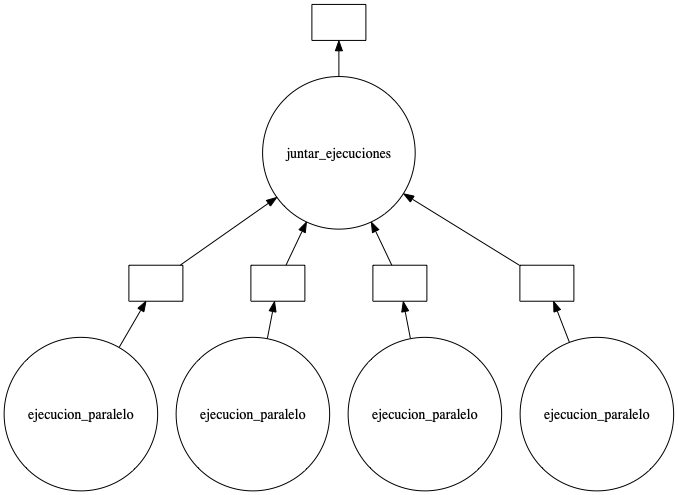

In [11]:
objControl.grafo_Ejecucion.visualize()

(En este caso se tienen 4 cores, por lo que se espera que el tiempo total de ejecución sea aproximadamente una cuarta parte del tiempo en secuencial).

Una vez que se cuenta con el grafo de ejecuión, mediante el método compute() solicitamos que se ejecute como tal el cálculo de las rutas en paralelo:

In [12]:
%%time
objControl.grafo_Ejecucion.compute()

--fza_ventas: --fza_ventas:  87795
--fza_ventas: --fza_ventas:  93997
 35673
 80060
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  54210
--fza_ventas: --fza_ventas:  50367
 94919
--fza_ventas:  57635
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  90318
--fza_ventas:  79974
--fza_ventas:  84424
--fza_ventas:  46388
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table us

--fza_ventas:  58137
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  90147
--fza_ventas:  33369
--fza_ventas:  84998
--fza_ventas: Selecting rows from table using cursor.fetchall 74603

PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  84302
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  89571
--fza_ventas:  95826
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  43753
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting r

Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  93906
--fza_ventas:  92487
--fza_ventas:  91694
--fza_ventas:  89009
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas: --fza_ventas:  83978
 94765
--fza_ventas:  78237
--fza_ventas:  89806
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using 

Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  90710
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  95165
--fza_ventas:  22729
Selecting rows from table using cursor.fetchall
--fza_ventas: PostgreSQL connection is closed 
75889
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  76079
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  75427
--fza_ventas:  75909
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  94397
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  83153
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_venta

--fza_ventas:  80953
--fza_ventas:  76011
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  86862
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  85712
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  83123
--fza_ventas:  50915
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  90300
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  91960
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closedSelecting rows from table using cursor.fetchall

PostgreSQL connection is closed
--fza_ventas:  82832
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  28937
--fza_ventas:  93192
Selecting rows from table using cursor.fetchall
P

--fza_ventas:  37525
--fza_ventas:  89016
--fza_ventas:  1143
--fza_ventas:  47420
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closedPostgreSQL connection is closed

--fza_ventas:  57522
--fza_ventas:  29375
--fza_ventas: --fza_ventas:  81663
 56573
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas: --fza_ventas:  82522
 73161
--fza_ventas:  52689
--fza_ventas:  93832
Selecting rows from table using cursor.fetchallSelecting rows from table using cursor.fetchall

PostgreSQL co

Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  87592
--fza_ventas:  94851
--fza_ventas:  78351
--fza_ventas:  18461
Selecting rows from table using cursor.fetchall
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  92411
--fza_ventas:  72293
--fza_ventas:  96217
--fza_ventas:  40454
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using 

Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  93840
--fza_ventas:  71531
--fza_ventas:  45502
--fza_ventas:  78888
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  92213
Selecting rows from table using cursor.fetchall
--fza_ventas:  PostgreSQL connection is closed87449

--fza_ventas:  87581
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  74775
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  94866
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  50551
--fza_ventas:  80059
Selecting rows from table using cursor.fetchall
P

--fza_ventas:  92424
--fza_ventas:  22146
--fza_ventas:  87797
--fza_ventas:  86282
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  58091
--fza_ventas:  95238
--fza_ventas:  41176
--fza_ventas:  30098
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
PostgreSQL connection is closed
--fza_ventas:  81834
--fza_ventas:  80510
--fza_ventas:  87021
--fza_ventas:  84470
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table us

--fza_ventas:  92132
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  47848
--fza_ventas:  57640
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  85659
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed--fza_ventas:  91092

Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  76849
--fza_ventas:  84315
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  48738
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  85662
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  54430
--fza_ventas:  89068
Selecting rows from table using cursor.fetchall
P

--fza_ventas:  46581
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  52611
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  44303
Selecting rows from table using cursor.fetchall
--fza_ventas: PostgreSQL connection is closed
 39723
--fza_ventas:  44669
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  80743
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  76633
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  89065
--fza_ventas:  10146
--fza_ventas:  23852
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection 

Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  85528
--fza_ventas:  78447
--fza_ventas:  91696
--fza_ventas:  34772
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
--fza_ventas:  85917
--fza_ventas:  92204
--fza_ventas:  38451
--fza_ventas:  74699
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed
Selecting rows from table using 

([0, 0, 0, 0],)

Como se puede apreciar, el tiempo total fue de casi 10 minutos, lo que coincide con la expectativa que se tenía al haber distribuido las fuerzas de venta de acuerdo al número de cores.

## Simulated Annealing

Esta implementación de Simulated Annealing no es posible correrla de manera paralela puesto que internamente hay código que está hecho para correr únicamente sobre el main thread, por lo que al tratar de realizar la corrida en paralelo se presenta un error.

Por lo anterior se procede a ejecutar el algoritmo de manera secuencial:

In [13]:
# objControl.CalcularRutasSeq(sa.SimulatedAnnealing, objControl.dict_Hiper_SA)